In [1]:
# set work dir
import os
os.chdir("../")

In [2]:
import time
import spo
import torch
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
torch.manual_seed(135)

Auto-Sklearn cannot be imported.


## Init Data

In [3]:
# generate data for grid network (features and costs)
m = 32 # number of items
n = 100 # number of data
p = 5 # size of feature
deg = 4 # polynomial degree
dim = 3 # dimension of knapsack
weights, x, c = spo.data.knapsack.genData(n+1000, p, m, deg=deg, dim=dim)

In [4]:
weights

array([[4.59, 4.87, 5.19, 7.59, 6.8 , 4.97, 4.84, 3.22, 7.9 , 3.62, 3.12,
        6.81, 7.09, 3.23, 4.47, 5.23, 6.11, 5.23, 4.27, 6.66, 5.21, 3.72,
        7.83, 5.64, 7.56, 3.28, 4.31, 3.85, 6.43, 4.26, 7.56, 6.4 ],
       [6.09, 6.4 , 4.5 , 6.31, 6.35, 3.07, 6.03, 7.39, 3.48, 5.57, 6.27,
        4.55, 5.64, 5.66, 3.27, 6.68, 4.2 , 5.61, 6.13, 7.88, 4.61, 4.92,
        6.09, 7.95, 7.11, 4.02, 3.07, 7.84, 6.29, 5.78, 5.57, 5.65],
       [7.41, 5.21, 3.42, 6.48, 5.77, 7.67, 7.32, 3.31, 4.36, 4.75, 3.38,
        3.44, 6.3 , 4.85, 7.09, 5.7 , 4.05, 6.04, 6.51, 3.41, 7.94, 6.05,
        7.18, 3.64, 4.35, 4.45, 4.27, 4.87, 5.74, 3.16, 5.41, 3.81]])

In [5]:
# convert max into min
c = - c

## Optimization Model 

In [6]:
# capacity
caps = [20, 20, 20]

In [7]:
ks_model = spo.model.grb.knapsackModel(weights, caps)

Set parameter Username
Academic license - for non-commercial use only - expires 2022-03-06


In [8]:
# solve
ks_model.setObj([-i for i in range(m)])
sol, obj = ks_model.solve()
print(sol)
print('Obj: {}'.format(obj))
for i in ks_model.items:
    if sol[i] > 1e-3:
        print(i)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0]
Obj: -111.0
25
26
29
31


In [9]:
# relax
ks_model_rel = ks_model.relax()

In [10]:
# solve
ks_model_rel.setObj([-i for i in range(m)])
sol, obj = ks_model_rel.solve()
print(sol)
print('Obj: {}'.format(obj))
for i in ks_model_rel.items:
    if sol[i] > 1e-3:
        print(i)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08748512880277728, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.18843324349916252, 1.0]
Obj: -118.4901850098332
21
25
26
29
30
31


## Data Loader 

In [11]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [12]:
# data split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)

In [13]:
# get training data set
ks_dataset_train = spo.data.dataset.optDataset(ks_model, x_train, c_train)

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 284.02it/s]


In [14]:
# get training data set for relaxation
ks_dataset_train_rel = spo.data.dataset.optDataset(ks_model_rel, x_train, c_train)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1315.46it/s]


In [15]:
# get test data set
ks_dataset_test = spo.data.dataset.optDataset(ks_model, x_test, c_test)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 311.85it/s]


In [16]:
# get data loader
batch_size = 32
ks_loader_train = DataLoader(ks_dataset_train, batch_size=batch_size, shuffle=True)
ks_loader_train_rel = DataLoader(ks_dataset_train_rel, batch_size=batch_size, shuffle=True)
ks_loader_test = DataLoader(ks_dataset_test, batch_size=batch_size, shuffle=False)

In [17]:
for i, data in enumerate(ks_loader_train):
    x, c, w, z = data
    break

In [18]:
x.shape

torch.Size([32, 5])

In [19]:
c.shape

torch.Size([32, 32])

In [20]:
w.shape

torch.Size([32, 32])

In [21]:
z.shape

torch.Size([32, 1])

## Linear Regression from Scikit-Lear 

In [22]:
from sklearn.linear_model import LinearRegression

In [23]:
# prediction model
reg = LinearRegression()

## Two-Stage 

In [24]:
# build model
twostage_model = spo.twostage.sklearnPred(reg)

In [25]:
# training
twostage_model.fit(ks_dataset_train.feats, ks_dataset_train.costs)

MultiOutputRegressor(estimator=LinearRegression())

In [26]:
# prediction
c_test_pred = twostage_model.predict(ks_dataset_test.feats)

In [27]:
# evaluate
truespo = 0
unambspo = 0
for i in tqdm(range(1000)):
    c_pred_i = c_test_pred[i]
    c_true_i = ks_dataset_test.costs[i]
    z_true_i = ks_dataset_test.objs[i,0]
    truespo += spo.eval.calTrueSPO(ks_model, c_pred_i, c_true_i, z_true_i)
    unambspo += spo.eval.calUnambSPO(ks_model, c_pred_i, c_true_i, z_true_i)
time.sleep(1)
print('Normalized true SPO Loss: {:.2f}%'.format(truespo / abs(ks_dataset_test.objs.sum()) * 100))
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(unambspo / abs(ks_dataset_test.objs.sum()) * 100))

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 69.75it/s]


Normalized true SPO Loss: 3.91%
Normalized unambiguous SPO Loss: 3.91%


In [28]:
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    # predict
    cp = twostage_model.predict(x)
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 2.00, 2.00, 1.00, 1.00, 3.00, 1.00, 2.00, 3.00, 1.00, 2.00, 2.00, 3.00, 2.00, 4.00, 3.00, 2.00, 3.00, 3.00, 1.00, 2.00, 2.00, 1.00, 2.00, 2.00, 3.00, 2.00, 2.00, 2.00, 2.00, 3.00, 1.00, 2.00
    Pred cost: 2.77, 2.42, 0.60, 0.43, 4.70, 0.43, 2.25, 3.40, 0.28, 2.77, 2.42, 3.40, 2.32, 3.95, 3.42, 2.36, 4.70, 4.70, 0.62, 2.12, 1.83, 0.60, 1.83, 2.05, 3.00, 2.12, 2.36, 2.12, 1.77, 3.40, 0.34, 2.77
    True sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, True obj: 13.00
    Pred sol: -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, 1, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, Pred obj: 12.00

Sample 1:
    True cost: 4.00, 3.00, 3.00, 5.00, 3.00, 5.00, 2.00, 3.00, 3.00, 4.00, 3.00, 3.00, 7.00, 2.00, 5.00, 3.00, 3.00, 3.00, 3.00, 4.00, 5.00, 3.00, 5.00, 4.00, 3.00, 4.00, 3.00, 4.00, 3.00, 3.00, 2.00, 4.00
    Pred cost: 6.10, 3.16, 5.14, 6.68, 4.65, 6.68, 1.31, 3.82, 4.57, 6.10, 3.16, 

## Two-Stage with Grid Search 

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

In [30]:
# build model
twostage_model = spo.twostage.sklearnPred(Ridge())

In [31]:
# creat scorer
spo_scorer = spo.eval.metrics.makeSkScorer(ks_model)

In [32]:
# build grid search
grid = GridSearchCV(twostage_model, param_grid={'estimator__alpha': [0, 0.1, 0.5]}, scoring=spo_scorer)

In [33]:
# training
grid.fit(ks_dataset_train.feats, ks_dataset_train.costs)

GridSearchCV(estimator=MultiOutputRegressor(estimator=Ridge()),
             param_grid={'estimator__alpha': [0, 0.1, 0.5]},
             scoring=make_scorer(SPOError, greater_is_better=False, model_type=<class 'spo.model.grb.knapsack.knapsackModel'>, args={'weights': array([[4.59, 4.87, 5.19, 7.59, 6.8 , 4.97, 4.84, 3.22, 7.9 , 3.62, 3.12,
        6.81, 7.09, 3.23, 4.47, 5.23, 6.11, 5.23, 4.27, 6.66, 5.21, 3.72,
        7...
       [6.09, 6.4 , 4.5 , 6.31, 6.35, 3.07, 6.03, 7.39, 3.48, 5.57, 6.27,
        4.55, 5.64, 5.66, 3.27, 6.68, 4.2 , 5.61, 6.13, 7.88, 4.61, 4.92,
        6.09, 7.95, 7.11, 4.02, 3.07, 7.84, 6.29, 5.78, 5.57, 5.65],
       [7.41, 5.21, 3.42, 6.48, 5.77, 7.67, 7.32, 3.31, 4.36, 4.75, 3.38,
        3.44, 6.3 , 4.85, 7.09, 5.7 , 4.05, 6.04, 6.51, 3.41, 7.94, 6.05,
        7.18, 3.64, 4.35, 4.45, 4.27, 4.87, 5.74, 3.16, 5.41, 3.81]]), 'capacity': array([20, 20, 20])}))

In [34]:
# prediction
c_test_pred = grid.predict(ks_dataset_test.feats)

In [35]:
# evaluate
truespo = 0
unambspo = 0
for i in tqdm(range(1000)):
    c_pred_i = c_test_pred[i]
    c_true_i = ks_dataset_test.costs[i]
    z_true_i = ks_dataset_test.objs[i,0]
    truespo += spo.eval.calTrueSPO(ks_model, c_pred_i, c_true_i, z_true_i)
    unambspo += spo.eval.calUnambSPO(ks_model, c_pred_i, c_true_i, z_true_i)
time.sleep(1)
print('Normalized true SPO Loss: {:.2f}%'.format(truespo / abs(ks_dataset_test.objs.sum()) * 100))
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(unambspo / abs(ks_dataset_test.objs.sum()) * 100))

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 66.52it/s]


Normalized true SPO Loss: 3.91%
Normalized unambiguous SPO Loss: 3.91%


In [36]:
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    # predict
    cp = grid.predict(x)
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 2.00, 2.00, 1.00, 1.00, 3.00, 1.00, 2.00, 3.00, 1.00, 2.00, 2.00, 3.00, 2.00, 4.00, 3.00, 2.00, 3.00, 3.00, 1.00, 2.00, 2.00, 1.00, 2.00, 2.00, 3.00, 2.00, 2.00, 2.00, 2.00, 3.00, 1.00, 2.00
    Pred cost: 2.77, 2.42, 0.60, 0.43, 4.70, 0.43, 2.25, 3.40, 0.28, 2.77, 2.42, 3.40, 2.32, 3.95, 3.42, 2.36, 4.70, 4.70, 0.62, 2.12, 1.83, 0.60, 1.83, 2.05, 3.00, 2.12, 2.36, 2.12, 1.77, 3.40, 0.34, 2.77
    True sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, True obj: 13.00
    Pred sol: -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, 1, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, Pred obj: 12.00

Sample 1:
    True cost: 4.00, 3.00, 3.00, 5.00, 3.00, 5.00, 2.00, 3.00, 3.00, 4.00, 3.00, 3.00, 7.00, 2.00, 5.00, 3.00, 3.00, 3.00, 3.00, 4.00, 5.00, 3.00, 5.00, 4.00, 3.00, 4.00, 3.00, 4.00, 3.00, 3.00, 2.00, 4.00
    Pred cost: 6.10, 3.16, 5.14, 6.68, 4.65, 6.68, 1.31, 3.82, 4.57, 6.10, 3.16, 

## Linear Regression from PyTorch

In [37]:
from torch import nn

In [38]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, m)
    
    def forward(self, x):
        out = self.linear(x)
        return out

## SPO+ 

In [39]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [40]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=5e-3)

In [41]:
# init SPO+ loss
criterion = spo.func.SPOPlus(ks_model, processes=4)

Num of cores: 4


In [42]:
# train model
num_epochs = 500
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:  54.7194, True SPO Loss: 42.6645%, Unambiguous SPO Loss: 42.6645%
Epoch  20, Loss:  20.4871, True SPO Loss: 38.7866%, Unambiguous SPO Loss: 38.7866%
Epoch  30, Loss:  19.6836, True SPO Loss: 34.5605%, Unambiguous SPO Loss: 34.5605%
Epoch  40, Loss:  22.8537, True SPO Loss: 30.4937%, Unambiguous SPO Loss: 30.4937%
Epoch  50, Loss:  17.4164, True SPO Loss: 26.8047%, Unambiguous SPO Loss: 26.8047%
Epoch  60, Loss:  19.2472, True SPO Loss: 23.6490%, Unambiguous SPO Loss: 23.6490%
Epoch  70, Loss:  24.8728, True SPO Loss: 21.1600%, Unambiguous SPO Loss: 21.1600%
Epoch  80, Loss:  33.4799, True SPO Loss: 19.4452%, Unambiguous SPO Loss: 19.4452%
Epoch  90, Loss:  13.8506, True SPO Loss: 18.4896%, Unambiguous SPO Loss: 18.4896%
Epoch 100, Loss:   9.0934, True SPO Loss: 15.7080%, Unambiguous SPO Loss: 15.7080%
Epoch 110, Loss:  15.5559, True SPO Loss: 13.9931%, Unambiguous SPO Loss: 13.9931%
Epoch 120, Loss:  10.4833, True SPO Loss: 12.3708%, Unambiguous SPO Loss: 12.3708%
Epoc

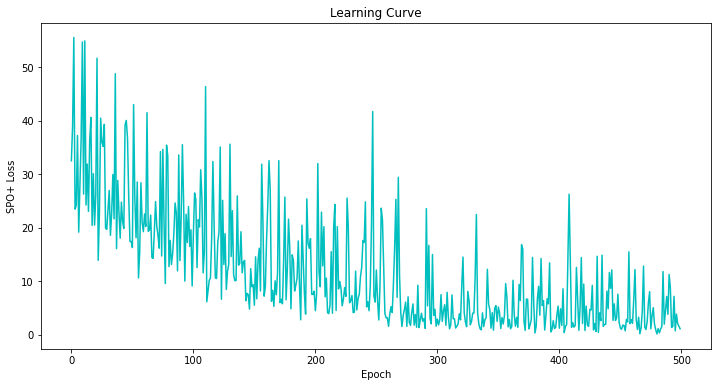

In [43]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

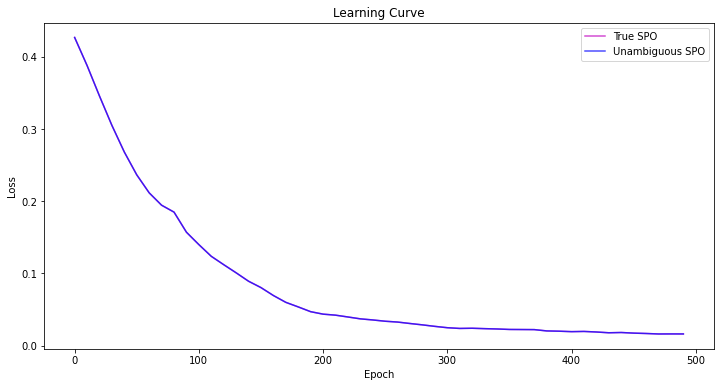

In [44]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [45]:
# evaluate
spoloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 1.63%
Normalized unambiguous SPO Loss: 1.63%


In [46]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 2.00, 2.00, 1.00, 1.00, 3.00, 1.00, 2.00, 3.00, 1.00, 2.00, 2.00, 3.00, 2.00, 4.00, 3.00, 2.00, 3.00, 3.00, 1.00, 2.00, 2.00, 1.00, 2.00, 2.00, 3.00, 2.00, 2.00, 2.00, 2.00, 3.00, 1.00, 2.00
    Pred cost: 2.91, 3.18, 0.59, -0.24, -1.81, 0.57, 3.27, 2.93, 1.11, 2.67, 2.82, 3.22, 2.53, 4.31, 3.69, 3.26, 4.25, 4.48, 0.78, 3.71, 2.13, 0.62, -0.61, 2.37, 3.92, 2.47, 2.50, 2.55, 1.60, 3.41, 0.72, 2.71
    True sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, True obj: 13.00
    Pred sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, Pred obj: 13.00

Sample 1:
    True cost: 4.00, 3.00, 3.00, 5.00, 3.00, 5.00, 2.00, 3.00, 3.00, 4.00, 3.00, 3.00, 7.00, 2.00, 5.00, 3.00, 3.00, 3.00, 3.00, 4.00, 5.00, 3.00, 5.00, 4.00, 3.00, 4.00, 3.00, 4.00, 3.00, 3.00, 2.00, 4.00
    Pred cost: 2.28, 2.05, 2.24, -0.01, -1.00, 3.65, 0.11, 2.37, 2.59, 3.13, 1.83, 2.04, 2.75, 0.79, 3.03,

## SPO+ Rel 

In [47]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [48]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=5e-3)

In [49]:
# init SPO+ loss
criterion = spo.func.SPOPlus(ks_model_rel, processes=4)

Num of cores: 4


In [50]:
# train model
num_epochs = 500
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train_rel):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:  59.7200, True SPO Loss: 44.0794%, Unambiguous SPO Loss: 44.0794%
Epoch  20, Loss:  21.9252, True SPO Loss: 40.0126%, Unambiguous SPO Loss: 40.0126%
Epoch  30, Loss:  32.9157, True SPO Loss: 35.9124%, Unambiguous SPO Loss: 35.9050%
Epoch  40, Loss:  26.6362, True SPO Loss: 32.8642%, Unambiguous SPO Loss: 32.8531%
Epoch  50, Loss:  36.3670, True SPO Loss: 27.1566%, Unambiguous SPO Loss: 27.1566%
Epoch  60, Loss:  37.1799, True SPO Loss: 24.4342%, Unambiguous SPO Loss: 24.4342%
Epoch  70, Loss:  30.0111, True SPO Loss: 22.2305%, Unambiguous SPO Loss: 22.2305%
Epoch  80, Loss:  15.3041, True SPO Loss: 20.1230%, Unambiguous SPO Loss: 20.1230%
Epoch  90, Loss:  15.0908, True SPO Loss: 17.8710%, Unambiguous SPO Loss: 17.8710%
Epoch 100, Loss:  14.8893, True SPO Loss: 16.1302%, Unambiguous SPO Loss: 16.1302%
Epoch 110, Loss:  28.4134, True SPO Loss: 13.8894%, Unambiguous SPO Loss: 13.8894%
Epoch 120, Loss:  13.6414, True SPO Loss: 12.0967%, Unambiguous SPO Loss: 12.0967%
Epoc

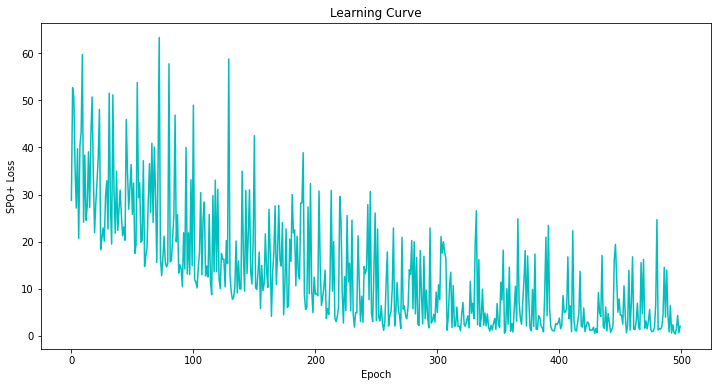

In [51]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

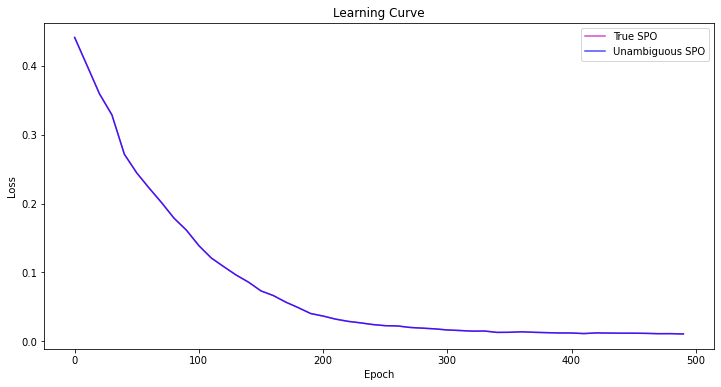

In [52]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [53]:
# evaluate
spoloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 1.08%
Normalized unambiguous SPO Loss: 1.08%


In [54]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 2.00, 2.00, 1.00, 1.00, 3.00, 1.00, 2.00, 3.00, 1.00, 2.00, 2.00, 3.00, 2.00, 4.00, 3.00, 2.00, 3.00, 3.00, 1.00, 2.00, 2.00, 1.00, 2.00, 2.00, 3.00, 2.00, 2.00, 2.00, 2.00, 3.00, 1.00, 2.00
    Pred cost: 2.48, 2.72, 0.47, 2.00, 4.12, 0.75, 2.57, 3.09, 1.26, 1.96, 2.45, 3.21, 1.82, 3.78, 3.53, 2.70, 4.12, 3.95, 1.01, 1.89, 1.55, -0.08, -0.20, 1.82, 3.39, 1.94, 2.30, 2.43, 1.25, 3.07, 0.46, 2.32
    True sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, True obj: 13.00
    Pred sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, Pred obj: 13.00

Sample 1:
    True cost: 4.00, 3.00, 3.00, 5.00, 3.00, 5.00, 2.00, 3.00, 3.00, 4.00, 3.00, 3.00, 7.00, 2.00, 5.00, 3.00, 3.00, 3.00, 3.00, 4.00, 5.00, 3.00, 5.00, 4.00, 3.00, 4.00, 3.00, 4.00, 3.00, 3.00, 2.00, 4.00
    Pred cost: 3.28, 1.90, 2.14, 2.15, 2.01, 3.70, -0.23, 2.25, 2.71, 3.04, 1.80, 2.16, 4.41, 0.66, 3.27, 1

## Black-Box

In [55]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [56]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-3)

In [57]:
# set loss
bb = spo.func.blackboxOpt(ks_model, lambd=10, processes=4)
criterion = nn.L1Loss()

Num of cores: 4


In [58]:
# train model
num_epochs = 500
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # linear regression
        cp = reg(x)
        # black-box optimizer
        wp = bb.apply(cp)
        # objective value
        zp = (wp * c).sum(1).view(-1, 1)
        # loss
        loss = criterion(zp, z)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:   9.7500, True SPO Loss: 42.6942%, Unambiguous SPO Loss: 42.6942%
Epoch  20, Loss:  10.5000, True SPO Loss: 38.7459%, Unambiguous SPO Loss: 38.7459%
Epoch  30, Loss:   6.7500, True SPO Loss: 35.1828%, Unambiguous SPO Loss: 35.1828%
Epoch  40, Loss:   6.2500, True SPO Loss: 32.3234%, Unambiguous SPO Loss: 32.3234%
Epoch  50, Loss:   9.7500, True SPO Loss: 29.7381%, Unambiguous SPO Loss: 29.7381%
Epoch  60, Loss:   5.5000, True SPO Loss: 26.9677%, Unambiguous SPO Loss: 26.9677%
Epoch  70, Loss:  10.5000, True SPO Loss: 24.8268%, Unambiguous SPO Loss: 24.8268%
Epoch  80, Loss:   4.2500, True SPO Loss: 22.2453%, Unambiguous SPO Loss: 22.2453%
Epoch  90, Loss:   2.0000, True SPO Loss: 19.8044%, Unambiguous SPO Loss: 19.8193%
Epoch 100, Loss:   1.5000, True SPO Loss: 17.8007%, Unambiguous SPO Loss: 17.8007%
Epoch 110, Loss:   1.7500, True SPO Loss: 15.7302%, Unambiguous SPO Loss: 15.7302%
Epoch 120, Loss:   9.5000, True SPO Loss: 14.6931%, Unambiguous SPO Loss: 14.6931%
Epoc

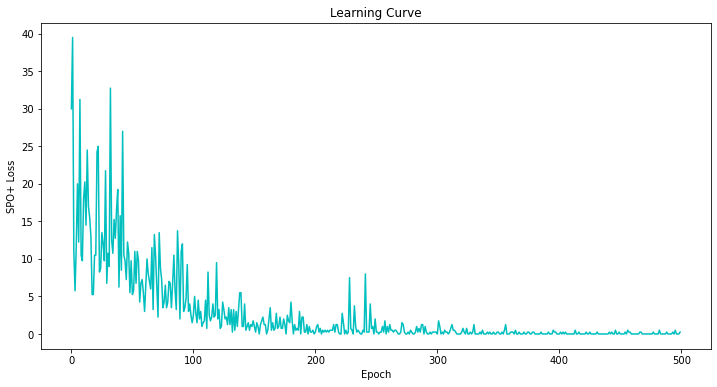

In [59]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

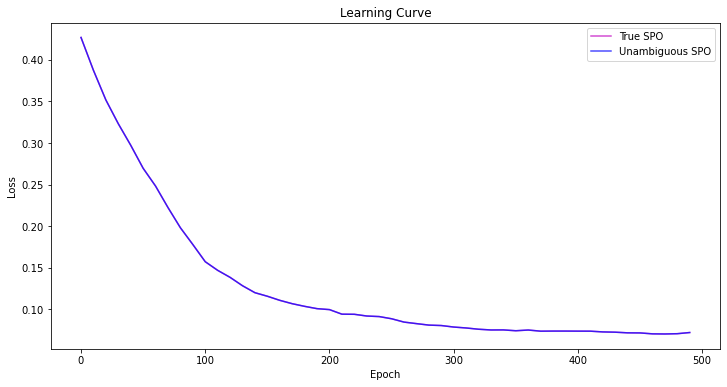

In [60]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [61]:
# evaluate
spoloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 7.22%
Normalized unambiguous SPO Loss: 7.22%


In [62]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 2.00, 2.00, 1.00, 1.00, 3.00, 1.00, 2.00, 3.00, 1.00, 2.00, 2.00, 3.00, 2.00, 4.00, 3.00, 2.00, 3.00, 3.00, 1.00, 2.00, 2.00, 1.00, 2.00, 2.00, 3.00, 2.00, 2.00, 2.00, 2.00, 3.00, 1.00, 2.00
    Pred cost: 0.28, -0.03, 0.01, -0.21, 0.14, -0.66, 0.18, -0.05, -0.86, -0.19, 0.18, 0.25, 0.01, 0.44, 0.50, -0.45, 0.40, 0.45, -0.69, -0.62, 0.37, -0.06, 0.16, -0.18, 0.58, 0.15, 0.13, -0.13, -0.23, 0.36, -0.52, 0.29
    True sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, True obj: 13.00
    Pred sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, Pred obj: 13.00

Sample 1:
    True cost: 4.00, 3.00, 3.00, 5.00, 3.00, 5.00, 2.00, 3.00, 3.00, 4.00, 3.00, 3.00, 7.00, 2.00, 5.00, 3.00, 3.00, 3.00, 3.00, 4.00, 5.00, 3.00, 5.00, 4.00, 3.00, 4.00, 3.00, 4.00, 3.00, 3.00, 2.00, 4.00
    Pred cost: 0.28, -0.10, 0.41, 0.19, -0.09, -0.01, -0.53, 0.39, -0.22, 0.21, 0.02, 0.16, 0.4